In [212]:
import requests
import bs4
from bs4 import BeautifulSoup
import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.core.display import HTML, Image
from sklearn.metrics import precision_score, auc, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV

In [213]:
# Created several functions to help us with scraping, cleaning, and polishing the 
# data.  

def get_soup_from_url(url):
    # Give us beautiful soup for an url
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,'lxml')
    return soup

def extract_location_from_result(result):
    # Scrapes the location from a single result on the Indeed website
    loca = result.find('span', class_ = 'location').text
    location = loca.split(',')[0]
    return str(location)

def extract_company_from_result(result):
    # Scrapes the company name from a single result on the Indeed website
    if result.find('span', class_ = 'company') == None:
        company = np.nan
    else:
        company = str(result.find('span', class_ = 'company').text.encode('ascii','ignore').strip())
    return company

def extract_jobtitle_from_result(result):
    # Scrapes the job title from a single result on the Indeed website
    jobtitle = result.find('a', class_ = 'jobtitle')
    if jobtitle != None:
        jobtitle = result.find('a',class_ = 'jobtitle').text.strip().encode('ascii','ignore')
    else:
        jobtitle = result.find('a').text.encode('ascii','ignore')
    return str(jobtitle)

def extract_salary_from_result(result):
    # Scrapes the salary from a single result on the Indeed website
    salary = result.find('nobr')
    if salary != None:
        salary = str(result.find('nobr').text)
    else:
        salary = np.nan
    return (salary)

def DollarDrop(x):
    # gets rid of the special characters in a dollar amount on the Indeed website
    y = x.split('$')
    z = y[1].replace(',','')
    return z

def SalarySplitter(x):
    # changes dollar amount from a string to a usable int (or nan if nothing there)
    x = str(x)
    a = x.strip().split(' ')
    tenor = a[-1]
    if tenor == 'year':
        if a[1] == '-':
            salary = (int(DollarDrop(a[0])) + int(DollarDrop(a[2])))/2
        else:
            salary = int(DollarDrop(a[0]))
    else:
        salary = np.nan
    return salary

def words_in_string(wordList, x):
    # matches the words for the word filter in lowercase letters
    for word in x.split():
        if word.lower() in wordList:
            return word.lower()
    return 'none'

In [214]:
#  Setting up a loop to take in several cities with max results to scrape for data
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={city}&start={start}"
max_results_per_city = 300

results = []

for city in set(['New+York', 'Chicago', 'Los+Angeles', 'Seattle', 'San+Francisco', 'Baltimore', 'Atlanta', 'Boston', 
                 'Dallas', 'Raleigh', 'Philadelphia']):
    url_prep = (url_template.replace('{city}',city))
    for start in range(0, max_results_per_city, 10):
        url = url_prep.replace('{start}',str(start))
        # Grabbing the results from the request (as above) with multiple cities then 
        # appending the full set of data to the results list
        soup = get_soup_from_url(url)
        for element in soup.findAll('div',class_ = 'result'):
            preResult=[]
            preResult.append(extract_jobtitle_from_result(element))
            preResult.append(extract_company_from_result(element))
            preResult.append(extract_location_from_result(element))
            cityTag = city.replace('+',' ')
            preResult.append(cityTag)
            preResult.append(extract_salary_from_result(element))
            results.append(preResult)
            
# Making a dataframe out of results complete with new column names, also making the numbers in salary
# ints instead of strings.  Finally dropping all na rows as we're interested in the rows with 
# salary information.
df = pd.DataFrame(results, columns  = ['JobTitle', 'CompanyName', 'City', 'CityGrouping', 'Salary'])
df['Salary'] = df['Salary'].apply(lambda x: SalarySplitter(x))
df.dropna(inplace = True)

In [215]:
len(results)

4947

In [5]:
#  Saving the dataframe to a csv file.  Important as it takes 2-3 minutes to do the scrape...
df.to_csv('SalaryInfo.csv')

## Analysis

In [3]:
# Reading in the csv... using this as a "checkpoint" when i have to redo calcs
workdf = pd.read_csv('SalaryInfo.csv')

In [4]:
# Getting the median of the salary to set up the "HighSalary" column, also setting up and
# then using the "expensive" words bucket to see if they have a bearing in job title
SalaryMedian = workdf['Salary'].median()
workdf['HighSalary']=[x>SalaryMedian for x in workdf['Salary']]
ExpensiveWords = ['senior', 'sr.', 'sr', 'manager']
workdf['WordTest'] = workdf['JobTitle'].apply(lambda x: words_in_string(ExpensiveWords,x))

In [222]:
SalaryMedian

110000.0

In [221]:
# Running logistic regression in statsmodel on the city groupings - please note
# we're running this on the cities we used for filtering rather than the actual
# city as there are many small cities that are lumped into the larger cities' filters
dummy_ranks = pd.get_dummies(workdf['CityGrouping'])
cols_to_keep = ['HighSalary']
data = workdf[cols_to_keep].join(dummy_ranks[list(dummy_ranks.columns[1:])])
data['intercept'] = 1.0
train_cols = data.columns[1:]
logit = sm.Logit(data['HighSalary'], data[train_cols])
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.584500
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.157     
Dependent Variable: HighSalary       AIC:              262.8138  
Date:               2016-07-08 09:54 BIC:              299.4205  
No. Observations:   206              Log-Likelihood:   -120.41   
Df Model:           10               LL-Null:          -142.75   
Df Residuals:       195              LLR p-value:      2.4784e-06
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Baltimore         -0.1490   0.6662 -0.2237 0.8230 -1.4548  1.1567
Boston             1.4816   0.6917  2.1421 0.0322  0.1260  2.8373
Chicago            2.0794   0.6614  3.1438 0.0017  0.7830  3.3758
Dallas             0.4700   0.7984  0.5887 0.5561 -1.0949  2.0349
Los Angeles       -0.3409   0.9347 -0.3648 0.7153 -2.1728  1.4910
New York           1.4508   0.6390  2.2704 0.0232  0.1984  2.7033
Philadelphia       1.3455   0.7932  1.6963 0.0898 -0.2092  2.9001
Raleigh            0.8755   0.7444  1.1760 0.2396 -0.5836  2.3345
San Francisco      2.4849   0.7610  3.2652 0.0011  0.9933  3.9765
Seattle            3.3604   1.1720  2.8672 0.0041  1.0633  5.6575
intercept         -1.1632   0.5123 -2.2702 0.0232 -2.1673 -0.1590
=================================================================

"""

In [6]:
# This logistic regression is done on key words in teh job title to see if there is 
# any effect. As we see from the results... there is not really any effect.
dummyWord_ranks = pd.get_dummies(workdf['WordTest'])
cols_to_keep = ['HighSalary']
dataWord = workdf[cols_to_keep].join(dummyWord_ranks[list(dummyWord_ranks.columns[1:])])
dataWord['intercept'] = 1.0
train_colsWord = dataWord.columns[1:]
logitWord = sm.Logit(dataWord['HighSalary'], dataWord[train_colsWord])
resultWord = logitWord.fit(method='bfgs')
resultWord.summary2()

         Current function value: 0.654152
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/michael/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.056    
Dependent Variable: HighSalary       AIC:              279.5105 
Date:               2016-07-07 17:10 BIC:              296.1499 
No. Observations:   206              Log-Likelihood:   -134.76  
Df Model:           4                LL-Null:          -142.75  
Df Residuals:       201              LLR p-value:      0.0030347
Converged:          0.0000           Scale:            1.0000   
----------------------------------------------------------------
             Coef.  Std.Err.    z    P>|z|    [0.025     0.975] 
----------------------------------------------------------------
none        -0.2201   0.9087 -0.2422 0.8086    -2.0010    1.5609
senior       1.3096   1.0060  1.3017 0.1930    -0.6622    3.2814
sr          14.1256 821.3902  0.0172 0.9863 -1595.7696 1624.0208
sr.         -0.7626   1.0752 -0.7092 0.4782    -2.8699    1.3447
intercept   -0.0105   0.8944 -0.0117 0.9907    -1.7635    1.7426
================================================================

"""

In [7]:
# Combining both the cities and "expensive" words to see how it looks.  it's just okay... 
dataFull = workdf[cols_to_keep].join(dummyWord_ranks[list(dummyWord_ranks.columns[1:])]).join(dummy_ranks[list(dummy_ranks.columns[1:])])
dataFull['intercept'] = 1.0
train_colsFull = dataFull.columns[1:]
logitFull = sm.Logit(dataFull['HighSalary'], dataFull[train_colsFull])
resultFull = logitFull.fit(method='bfgs')
resultFull.summary2()

         Current function value: 0.563781
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/michael/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.186     
Dependent Variable: HighSalary       AIC:              262.2778  
Date:               2016-07-07 17:10 BIC:              312.1960  
No. Observations:   206              Log-Likelihood:   -116.14   
Df Model:           14               LL-Null:          -142.75   
Df Residuals:       191              LLR p-value:      1.7445e-06
Converged:          0.0000           Scale:            1.0000    
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
none           -0.2500    0.9649  -0.2590  0.7956  -2.1412  1.6412
senior          1.0065    1.0767   0.9348  0.3499  -1.1038  3.1168
sr              2.6259    2.4042   1.0922  0.2747  -2.0862  7.3380
sr.            -0.6093    1.1856  -0.5139  0.6073  -2.9331  1.7145
Baltimore      -0.1517    0.6839  -0.2218  0.8244  -1.4921  1.1887
Boston          1.1626    0.7184   1.6183  0.1056  -0.2455  2.5708
Chicago         1.7411    0.6688   2.6035  0.0092   0.4304  3.0519
Dallas          0.4199    0.8250   0.5089  0.6108  -1.1971  2.0368
Los Angeles    -0.6156    0.9861  -0.6243  0.5324  -2.5484  1.3171
New York        1.2784    0.6552   1.9513  0.0510  -0.0057  2.5625
Philadelphia    1.1155    0.8170   1.3653  0.1722  -0.4858  2.7168
Raleigh         0.6535    0.7766   0.8415  0.4001  -0.8686  2.1756
San Francisco   2.1857    0.7830   2.7914  0.0052   0.6510  3.7203
Seattle         3.5346    1.3015   2.7157  0.0066   0.9836  6.0855
intercept      -0.9280    1.0509  -0.8831  0.3772  -2.9877  1.1316
=================================================================

"""

# Redoing the logistic regression models in scikit

In [8]:
# Setting the target and data variables to the full dataset (Using both "good" words and cities)
y = dataFull['HighSalary']
X= dataFull[train_colsFull]

In [9]:
# Running the test-train-split, fitting and predicting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

lr = LogisticRegression(solver='liblinear')
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

# Confusion matrix generation
lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,False,True
False,24,11
True,18,15


In [62]:
# Classification report generation
print(classification_report(y_test, lr_ypred, labels=lr.classes_))

# Getting the cross val score and also the accuracy score
print(cross_val_score(lr, X, y, cv=3).mean())
print(accuracy_score(y_test, lr_ypred))

             precision    recall  f1-score   support

      False       0.62      0.69      0.65        35
       True       0.62      0.55      0.58        33

avg / total       0.62      0.62      0.62        68

0.475987496448
0.617647058824


# L1 and L2 regularization

In [12]:
# Looking at L1 and L2 regularization, setting both up and printing both confusion matrices
lr1 = LogisticRegression(penalty='l1')
lr2 = LogisticRegression(penalty='l2')

lr1_model = lr1.fit(X_train, y_train)
lr2_model = lr2.fit(X_train, y_train)

y1_pred = lr1.predict(X_test)
y2_pred = lr2.predict(X_test)

cm1 = confusion_matrix(y_test, y1_pred, labels=lr1.classes_)
cm1 = pd.DataFrame(cm1, columns=lr1.classes_, index=lr1.classes_)

cm2 = confusion_matrix(y_test, y2_pred, labels=lr2.classes_)
cm2 = pd.DataFrame(cm2, columns=lr2.classes_, index=lr2.classes_)

In [13]:
cm1

,False,True
False,26,9
True,20,13


In [14]:
cm2

,False,True
False,24,11
True,18,15


In [63]:
print(classification_report(y_test, y1_pred, labels=lr2.classes_))

# for l1 regularization
print(cross_val_score(lr1, X, y, cv=3).mean())
print(accuracy_score(y_test, y1_pred))

             precision    recall  f1-score   support

      False       0.59      0.86      0.70        35
       True       0.71      0.36      0.48        33

avg / total       0.65      0.62      0.59        68

0.451832907076
0.617647058824


In [64]:
print(classification_report(y_test, y2_pred, labels=lr1.classes_))

# for l2 regularization
print(cross_val_score(lr2, X, y, cv=3).mean())
print(accuracy_score(y_test, y2_pred))

             precision    recall  f1-score   support

      False       0.59      0.86      0.70        35
       True       0.71      0.36      0.48        33

avg / total       0.65      0.62      0.59        68

0.475987496448
0.617647058824


# Cross val logistic regression

In [17]:
# Taking a look at cross val logistic regression
lrcv = LogisticRegressionCV(penalty='l1', solver='liblinear')
lrcv_model = lrcv.fit(X_train, y_train)
lrcv_ypred = lrcv_model.predict(X_test)
lrcv_model.C_

array([ 2.7825594])

In [18]:
# Confusion matrix for the LogReg CV
lrcv_cm = confusion_matrix(y_test, lrcv_ypred, labels=lrcv.classes_)
lrcv_cm = pd.DataFrame(lrcv_cm, columns=lrcv.classes_, index=lrcv.classes_)
lrcv_cm

,False,True
False,24,11
True,18,15


In [65]:
# Printing the classification report for the LogRegCV
print(classification_report(y_test, lrcv_ypred, labels=lrcv.classes_))

# Getting the cross val score and also the accuracy score for l1 and l2
# for l1 regularization
print(cross_val_score(lrcv, X, y, cv=3).mean())
print(accuracy_score(y_test, lrcv_ypred))

             precision    recall  f1-score   support

      False       0.57      0.69      0.62        35
       True       0.58      0.45      0.51        33

avg / total       0.57      0.57      0.57        68

0.509732878659
0.573529411765


# Grid search optimization

In [20]:
# Using grid search to find the best C Values along an array of C Values
logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X, y)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [21]:
gs.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [22]:
logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
cv_model = logreg.fit(X_train, y_train)
cv_pred = cv_model.predict(X_test)

cm3 = confusion_matrix(y_test, cv_pred, labels=logreg.classes_)
cm3 = pd.DataFrame(cm3, columns=logreg.classes_, index=logreg.classes_)

cm3

,False,True
False,32,3
True,26,7


In [66]:
print(classification_report(y_test, cv_pred, labels=logreg.classes_))

# Getting the cross val score and also the accuracy score
print(cross_val_score(cv_model, X, y, cv=3).mean())
print(accuracy_score(y_test, cv_pred))

             precision    recall  f1-score   support

      False       0.55      0.91      0.69        35
       True       0.70      0.21      0.33        33

avg / total       0.62      0.57      0.51        68

0.553282182438
0.573529411765


# New Features and Classifications

Trying a new set of classifications to see if they have any bearing on salaries.  In this case, we're going to see if the company itself has any significant bearing on the salary.  We'll be using a basket of the "recruiting" names in tech to see if they pay out better than the companies looking for candidates directly, i.e. do companies like Workbridge Associates, Staffing companies, etc advertise a premium to others in data science?  

In [24]:
# Reading in the csv to start "afresh"... using this as a "checkpoint" when i have to redo calcs
newWorkdf = pd.read_csv('SalaryInfo.csv')

In [25]:
# Getting the median of the salary to set up the "HighSalary" column, also setting up and
# then using the "expensive" words bucket to see if they have a bearing in job title
SalaryMedian = newWorkdf['Salary'].median()
newWorkdf['HighSalary']=[x>SalaryMedian for x in newWorkdf['Salary']]
CompanyNames = ['associates','employment','staffing','search','hanley','careers', 'jobspring']
newWorkdf['CompanyTest'] = newWorkdf['CompanyName'].apply(lambda x: words_in_string(CompanyNames,x))

In [34]:
# This logistic regression is done on key words in the company name to see if there is 
# any effect.
dummyCompany_ranks = pd.get_dummies(newWorkdf['CompanyTest'], prefix ='C')
cols_to_keep = ['HighSalary']
dataCompany = newWorkdf[cols_to_keep].join(dummyCompany_ranks[list(dummyCompany_ranks.columns[1:])])
dataCompany['intercept'] = 1.0
train_colsCompany = dataCompany.columns[1:]
logitCompany = sm.Logit(dataCompany['HighSalary'], dataCompany[train_colsCompany])
resultCompany = logitCompany.fit(method='bfgs')
resultCompany.summary2()

         Current function value: 0.618203
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/Users/michael/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.108     
Dependent Variable: HighSalary       AIC:              270.6995  
Date:               2016-07-07 17:16 BIC:              297.3225  
No. Observations:   206              Log-Likelihood:   -127.35   
Df Model:           7                LL-Null:          -142.75   
Df Residuals:       198              LLR p-value:      6.7696e-05
Converged:          0.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
C_careers        -3.4243   2.3160 -1.4785 0.1393  -7.9635  1.1149
C_employment      3.0726  10.1820  0.3018 0.7628 -16.8838 23.0290
C_hanley         -3.2360   1.1329 -2.8564 0.0043  -5.4564 -1.0156
C_jobspring      -2.6121   1.1861 -2.2023 0.0276  -4.9367 -0.2875
C_none           -2.9057   0.8751 -3.3203 0.0009  -4.6209 -1.1905
C_search         -1.9492   1.2217 -1.5955 0.1106  -4.3438  0.4453
C_staffing       -7.4409   5.5888 -1.3314 0.1831 -18.3947  3.5130
intercept         2.6536   0.8601  3.0852 0.0020   0.9678  4.3394
=================================================================

"""

In [35]:
y = dataCompany['HighSalary']
X= dataCompany[train_colsCompany]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

lr = LogisticRegression(solver='liblinear')
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

# Confusion matrix generation
lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,False,True
False,30,5
True,21,12


In [36]:
# Classification report generation
print(classification_report(y_test, lr_ypred, labels=lr.classes_))

             precision    recall  f1-score   support

      False       0.59      0.86      0.70        35
       True       0.71      0.36      0.48        33

avg / total       0.65      0.62      0.59        68



In [37]:
print(cross_val_score(lr, X, y, cv=3).mean())
print(accuracy_score(y_test, lr_ypred))

0.572605853936
0.617647058824


In [38]:
# Looking at L1 and L2 regularization
lr1 = LogisticRegression(penalty='l1')
lr2 = LogisticRegression(penalty='l2')

lr1_model = lr1.fit(X_train, y_train)
lr2_model = lr2.fit(X_train, y_train)

y1_pred = lr1.predict(X_test)
y2_pred = lr2.predict(X_test)

cm1 = confusion_matrix(y_test, y1_pred, labels=lr1.classes_)
cm1 = pd.DataFrame(cm1, columns=lr1.classes_, index=lr1.classes_)

cm2 = confusion_matrix(y_test, y2_pred, labels=lr2.classes_)
cm2 = pd.DataFrame(cm2, columns=lr2.classes_, index=lr2.classes_)

In [39]:
cm1

,False,True
False,30,5
True,21,12


In [40]:
cm2

,False,True
False,30,5
True,21,12


In [209]:
# Combining  the cities, "company" words, and "expensive" words to see how it looks.  it's just okay... 
dataFullSet = newWorkdf[cols_to_keep].join(dummyWord_ranks[list(dummyWord_ranks.columns[1:])]).join(dummy_ranks[list(dummy_ranks.columns[1:])]).join(dummyCompany_ranks[list(dummyCompany_ranks.columns[1:])])
dataFullSet['intercept'] = 1.0
train_colsFullSet = dataFullSet.columns[1:]
logitFullSet = sm.Logit(dataFullSet['HighSalary'], dataFullSet[train_colsFull])
resultFullSet = logitFullSet.fit(method='bfgs')
resultFullSet.summary2()

         Current function value: 0.563781
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/michael/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.186     
Dependent Variable: HighSalary       AIC:              262.2778  
Date:               2016-07-08 09:07 BIC:              312.1960  
No. Observations:   206              Log-Likelihood:   -116.14   
Df Model:           14               LL-Null:          -142.75   
Df Residuals:       191              LLR p-value:      1.7445e-06
Converged:          0.0000           Scale:            1.0000    
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
none           -0.2500    0.9649  -0.2590  0.7956  -2.1412  1.6412
senior          1.0065    1.0767   0.9348  0.3499  -1.1038  3.1168
sr              2.6259    2.4042   1.0922  0.2747  -2.0862  7.3380
sr.            -0.6093    1.1856  -0.5139  0.6073  -2.9331  1.7145
Baltimore      -0.1517    0.6839  -0.2218  0.8244  -1.4921  1.1887
Boston          1.1626    0.7184   1.6183  0.1056  -0.2455  2.5708
Chicago         1.7411    0.6688   2.6035  0.0092   0.4304  3.0519
Dallas          0.4199    0.8250   0.5089  0.6108  -1.1971  2.0368
Los Angeles    -0.6156    0.9861  -0.6243  0.5324  -2.5484  1.3171
New York        1.2784    0.6552   1.9513  0.0510  -0.0057  2.5625
Philadelphia    1.1155    0.8170   1.3653  0.1722  -0.4858  2.7168
Raleigh         0.6535    0.7766   0.8415  0.4001  -0.8686  2.1756
San Francisco   2.1857    0.7830   2.7914  0.0052   0.6510  3.7203
Seattle         3.5346    1.3015   2.7157  0.0066   0.9836  6.0855
intercept      -0.9280    1.0509  -0.8831  0.3772  -2.9877  1.1316
=================================================================

"""

In [46]:
y = dataFullSet['HighSalary']
X= dataFullSet[train_colsFullSet]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

lr = LogisticRegression(solver='liblinear')
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

# Confusion matrix generation
lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,False,True
False,24,11
True,15,18


In [47]:
# Classification report generation
print(classification_report(y_test, lr_ypred, labels=lr.classes_))

             precision    recall  f1-score   support

      False       0.62      0.69      0.65        35
       True       0.62      0.55      0.58        33

avg / total       0.62      0.62      0.62        68



In [48]:
print(cross_val_score(lr, X, y, cv=3).mean())
print(accuracy_score(y_test, lr_ypred))

0.45666382495
0.617647058824


# ROC curve generation

So after looking at several different features and combination of features, it appears that the less complicated set of features has a better cross val and accuracy score than the combination of features.  Let's take a look at ROC curves in the case of the original combination of features - "good" words and cities.  

In [94]:
# Setting the target and data variables to the full dataset (Using both "good" words and cities)
y = dataFull['HighSalary']
X= dataFull[train_colsFull]

lr = LogisticRegression()
lr_model = lr.fit(X, y)
predictions = lr_model.predict(X)

proba = lr_model.predict_proba(X).T[1]
roc = roc_curve(y, proba)


In [95]:
def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')
    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')

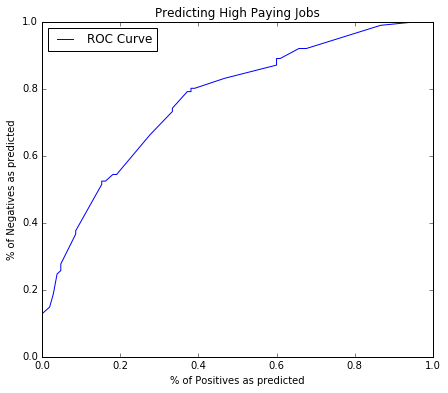

In [96]:
getROCcurve(roc, title='Predicting High Paying Jobs', ylabel='% of Negatives as predicted',\
            xlabel='% of Positives as predicted')

In [98]:
stuffdf = pd.read_csv('SalaryInfo.csv')

In [100]:
# Getting the median of the salary to set up the "HighSalary" column, also setting up and
# then using the "expensive" words bucket to see if they have a bearing in job title
SalaryMedian = stuffdf['Salary'].median()
stuffdf['HighSalary']=[x>SalaryMedian for x in stuffdf['Salary']]
CompanyNames = ['associates','employment','staffing','search','hanley','careers', 'jobspring']
stuffdf['CompanyTest'] = stuffdf['CompanyName'].apply(lambda x: words_in_string(CompanyNames,x))

In [190]:
stuffNewyork=stuffdf[stuffdf['CityGrouping']=='New York']
stuffChicago=stuffdf[stuffdf['CityGrouping']=='Chicago']
stuffLosangeles=stuffdf[stuffdf['CityGrouping']=='Los Angeles']
stuffSeattle=stuffdf[stuffdf['CityGrouping']=='Seattle']
stuffSanfrancisco=stuffdf[stuffdf['CityGrouping']=='San Francisco']
stuffBaltimore=stuffdf[stuffdf['CityGrouping']=='Baltimore']
stuffAtlanta=stuffdf[stuffdf['CityGrouping']=='Atlanta']
stuffBoston=stuffdf[stuffdf['CityGrouping']=='Boston']
stuffDallas=stuffdf[stuffdf['CityGrouping']=='Dallas']
stuffRaleigh=stuffdf[stuffdf['CityGrouping']=='Raleigh']
stuffPhiladelphia=stuffdf[stuffdf['CityGrouping']=='Philadelphia']


In [220]:
print('Mean salary overall: ' +  str(int(np.mean(stuffdf['Salary']))))
print('Mean salary in New York: ' +  str(int(np.mean(stuffNewyork['Salary']))))
print('Mean salary in Chicago: ' + str(int(np.mean(stuffChicago['Salary']))))
print('Mean salary in Los Angeles: ' + str(int(np.mean(stuffLosangeles['Salary']))))
print('Mean salary in Seattle: ' + str(int(np.mean(stuffSeattle['Salary']))))
print('Mean salary in San Francisco: ' + str(int(np.mean(stuffSanfrancisco['Salary']))))
print('Mean salary in Baltimore: ' + str(int(np.mean(stuffBaltimore['Salary']))))
print('Mean salary in Atlanta: ' + str(int(np.mean(stuffAtlanta['Salary']))))
print('Mean salary in Boston: ' + str(int(np.mean(stuffBoston['Salary']))))
print('Mean salary in Dallas: ' + str(int(np.mean(stuffDallas['Salary']))))
print('Mean salary in Raleigh: ' + str(int(np.mean(stuffRaleigh['Salary']))))
print('Mean salary in Philadelphia: ' + str(int(np.mean(stuffPhiladelphia['Salary']))))


Mean salary overall: 113559
Mean salary in New York: 131039
Mean salary in Chicago: 130421
Mean salary in Los Angeles: 97091
Mean salary in Seattle: 146750
Mean salary in San Francisco: 135839
Mean salary in Baltimore: 81594
Mean salary in Atlanta: 95214
Mean salary in Boston: 124829
Mean salary in Dallas: 97958
Mean salary in Raleigh: 97582
Mean salary in Philadelphia: 122755


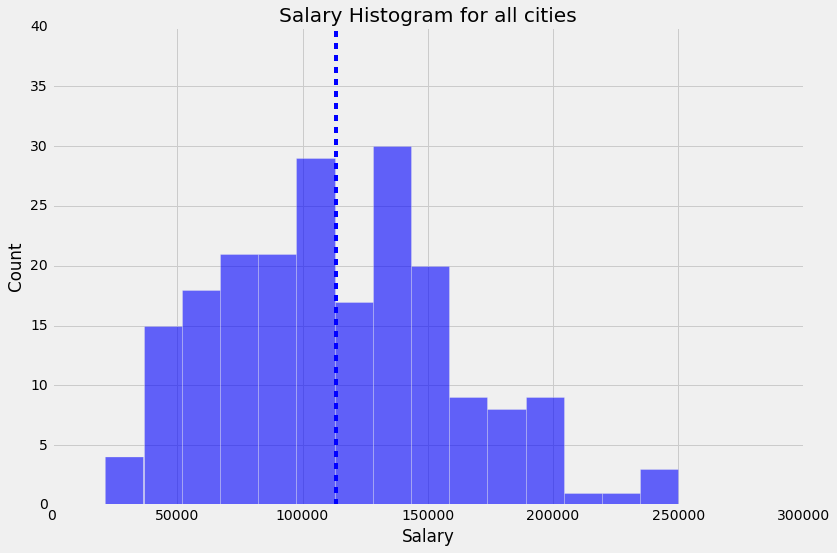

In [219]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffdf['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for all cities')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,40])
plt.axvline(np.mean(stuffdf['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

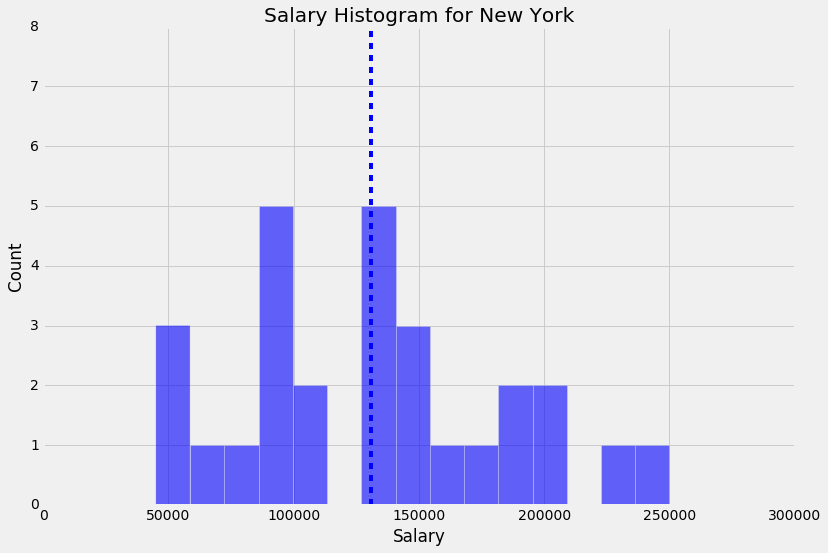

In [177]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffNewyork['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for New York')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffNewyork['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

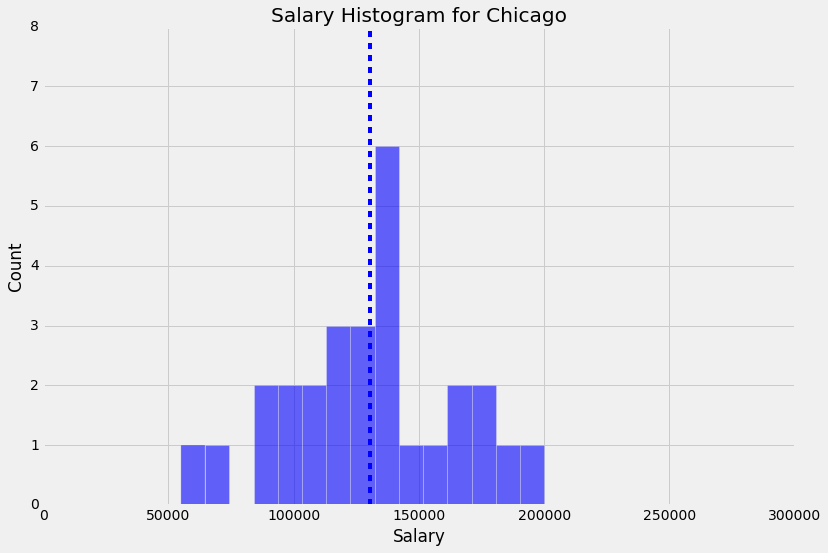

In [178]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffChicago['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Chicago')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffChicago['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

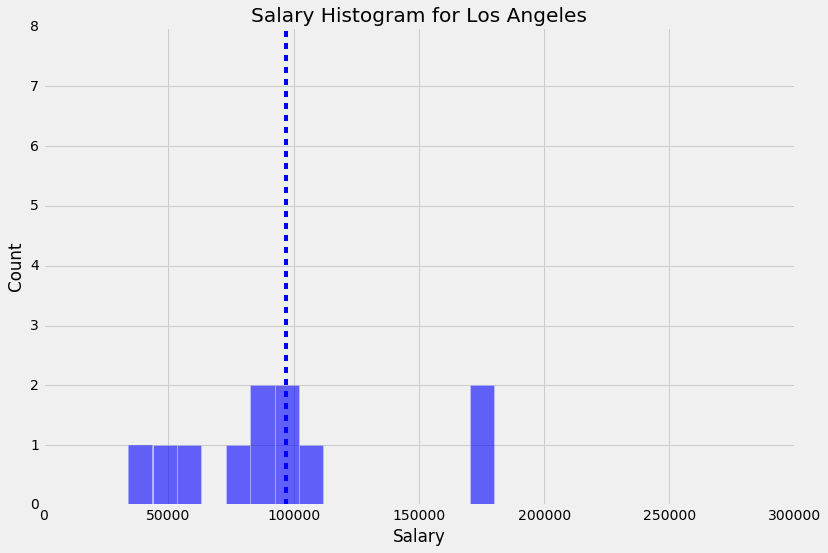

In [179]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffLosangeles['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Los Angeles')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffLosangeles['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

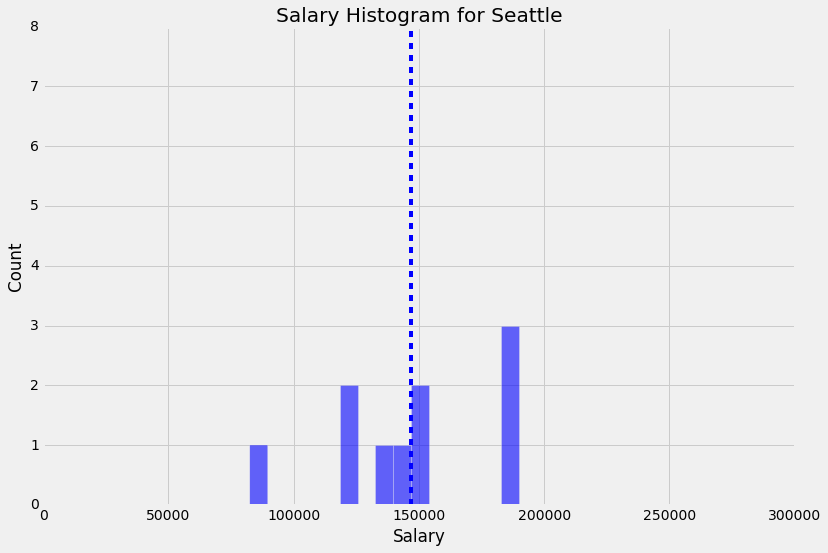

In [180]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffSeattle['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Seattle')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffSeattle['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

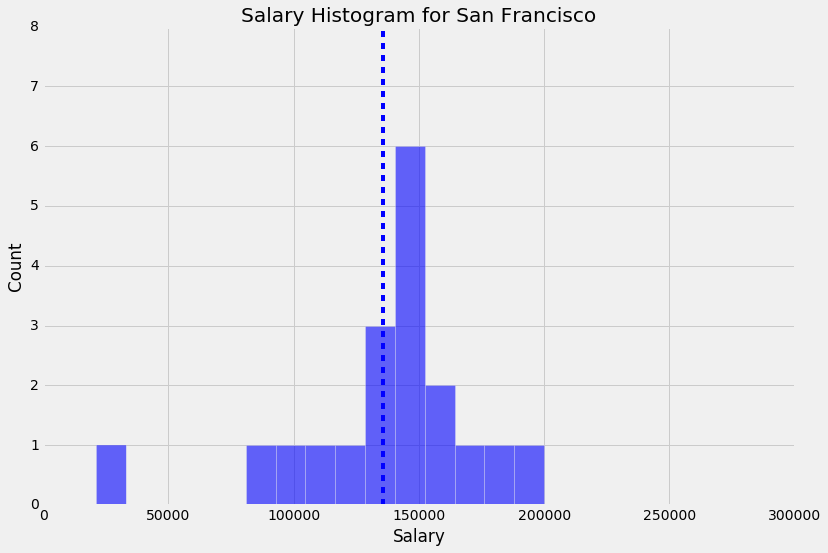

In [181]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffSanfrancisco['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for San Francisco')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffSanfrancisco['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

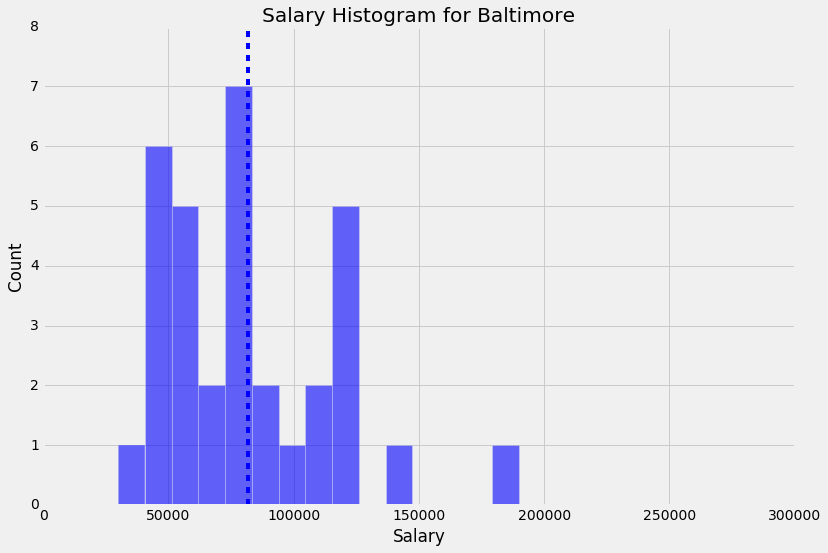

In [182]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffBaltimore['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Baltimore')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffBaltimore['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

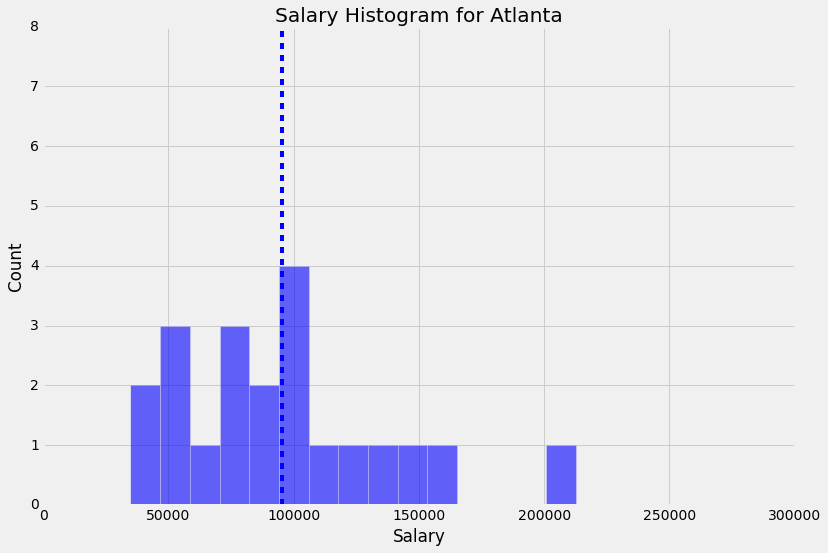

In [183]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffAtlanta['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Atlanta')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffAtlanta['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

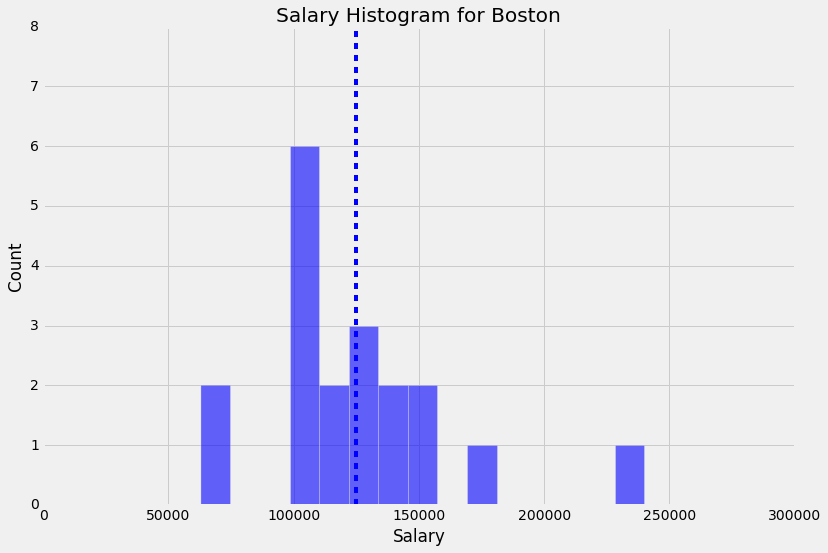

In [184]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffBoston['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Boston')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffBoston['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

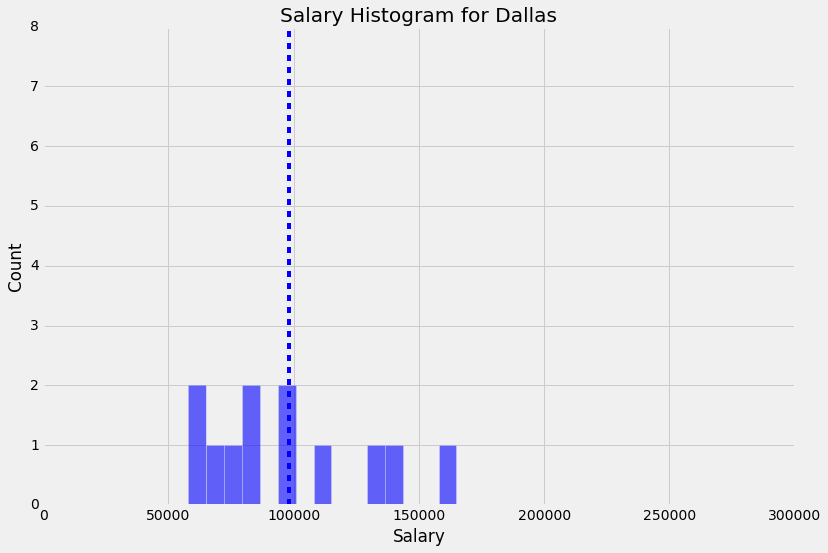

In [185]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffDallas['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Dallas')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffDallas['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

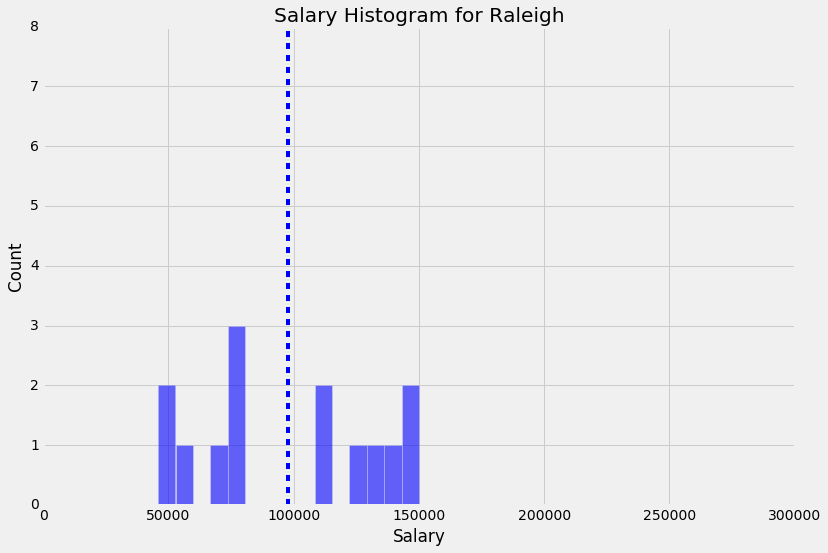

In [186]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffRaleigh['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Raleigh')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffRaleigh['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()

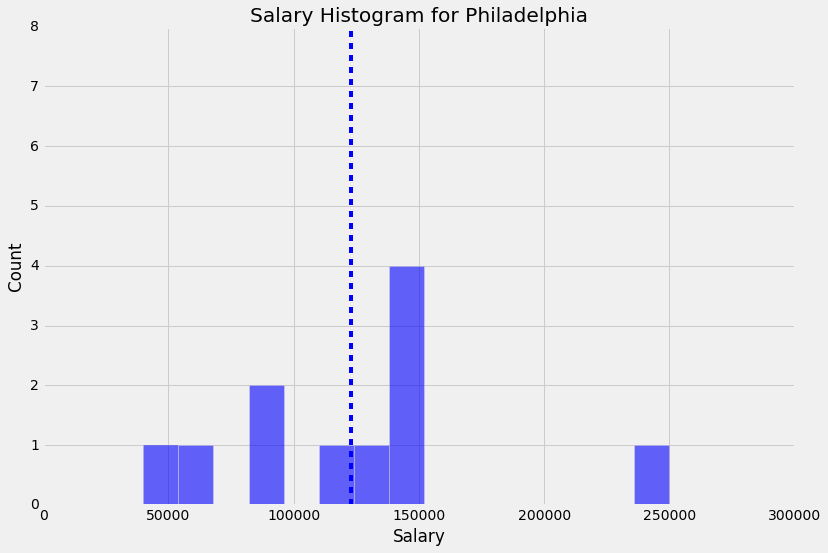

In [187]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,8))
axes = fig.gca()
plt.hist(stuffPhiladelphia['Salary'], 15, facecolor ='blue', alpha = 0.6)
plt.title('Salary Histogram for Philadelphia')
plt.xlabel('Salary')
plt.ylabel('Count')
axes.set_xlim([0,300000])
axes.set_ylim([0,8])
plt.axvline(np.mean(stuffPhiladelphia['Salary']), color = 'blue', linestyle = 'dashed')
plt.show()